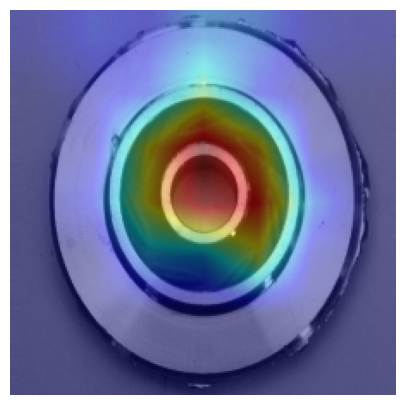

In [4]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
from torchvision.models import efficientnet_b0
from torch import nn
from PIL import Image
import cv2

# 모델 로드 및 수정 함수
def load_model(num_classes, pretrained):
    model = efficientnet_b0(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    model = model.to('cpu')
    model.eval()
    return model

# 특성 맵 추출을 위한 훅 등록
def hook_fn(module, input, output):
    global activated_features
    activated_features = output.detach()

if __name__ == "__main__":
    device = torch.device("cpu")
    model_name = "efficientnet_b0_weights_customTrained.pth"
    pretrained = True

    img_path = 'C:/pratice_data/casting/data/def_front/cast_def_0_1949.jpeg'
    img = Image.open(img_path)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img_cv = cv2.resize(img_cv, (224, 224))
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_img = transform(img).unsqueeze(0).to(device)

    # 모델 로드 및 훅 등록
    model = load_model(2, pretrained)
    handle = model._modules.get('features').register_forward_hook(hook_fn)

    # 모델을 통과시키기
    output = model(input_img)
    weight_softmax = model.classifier[1].weight.data
    class_idx = torch.argmax(output)

    # CAM 생성
    cam = torch.mm(weight_softmax[class_idx].unsqueeze(0), activated_features.reshape((activated_features.size(1), -1)))
    cam = cam.reshape(activated_features.shape[2], activated_features.shape[3])
    cam = F.relu(cam)
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
    cam = cam.squeeze(0).squeeze(0)
    cam_img = cam.cpu().numpy() / cam.max()

    # CAM을 원본 이미지 위에 반투명하게 표시
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_img), cv2.COLORMAP_JET)
    result = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


도어 외관손상 CAM 결과


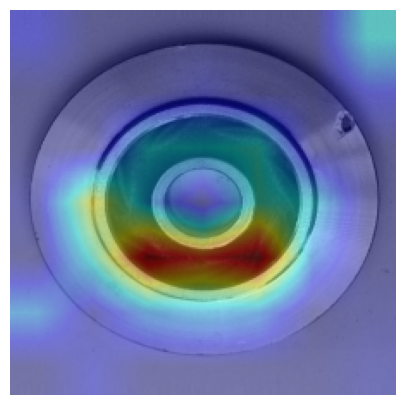

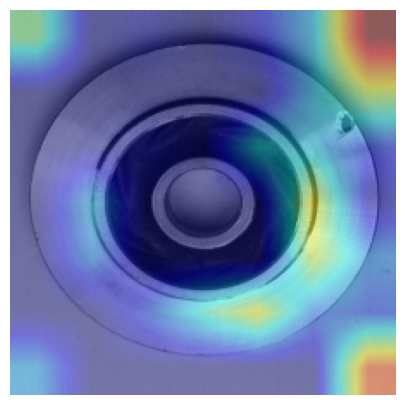

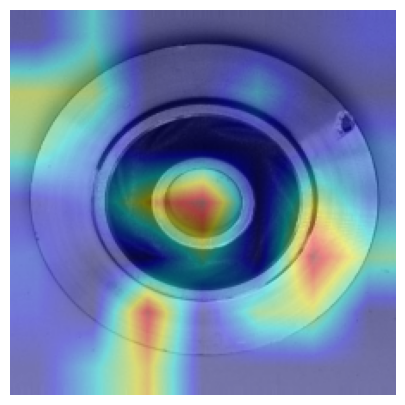

In [46]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
from torchvision.models import efficientnet_b0
from torch import nn
from PIL import Image
import cv2

# 모델 로드 및 수정 함수
def load_model(name, num_classes, pretrained):
    model = efficientnet_b0(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    if not pretrained:
        if name == "도어외관손상.pth":
            model.load_state_dict(torch.load(name, map_location='cpu'))
        else:
            model = efficientnet_b0(pretrained=False)
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    model = model.to('cpu')
    model.eval()
    return model

# 특성 맵 추출을 위한 훅 등록
final_conv = 'features'
activated_features = None
def hook_fn(module, input, output):
    global activated_features
    activated_features = output.detach()

if __name__ == "__main__":
    device = torch.device("cpu")
    model_names = ["efficientnet_b0_weights_pretrained.pth", "도어외관손상.pth", "efficientnet_b0_weights_notPretrained.pth"]
    pretrained_status = [True, False, False]

    img = Image.open('C:/pratice_data/casting/data/def_front/cast_def_0_93.jpeg')
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img_cv = cv2.resize(img_cv, (224, 224))
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_img = transform(img).unsqueeze(0).to(device)

    for i, model_name in enumerate(model_names):
        model = load_model(model_name, 2, pretrained_status[i])
        handle = model._modules.get(final_conv).register_forward_hook(hook_fn)

        output = model(input_img)
        weight_softmax = model.classifier[1].weight.data
        class_idx = torch.argmax(output)

        cam = torch.mm(weight_softmax[class_idx].unsqueeze(0), activated_features.reshape((activated_features.size(1), -1)))
        cam = cam.reshape(activated_features.shape[2], activated_features.shape[3])
        cam = F.relu(cam)
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze(0).squeeze(0)
        cam_img = cam.cpu().numpy() / cam.max()

        # CAM을 원본 이미지 위에 반투명하게 표시
        heatmap = cv2.applyColorMap(np.uint8(255*cam_img), cv2.COLORMAP_JET)
        result = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


배선 고정 불량 CAM 결과

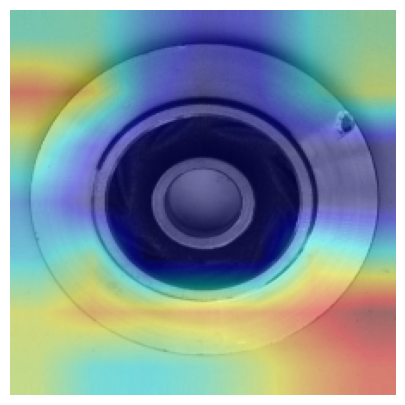

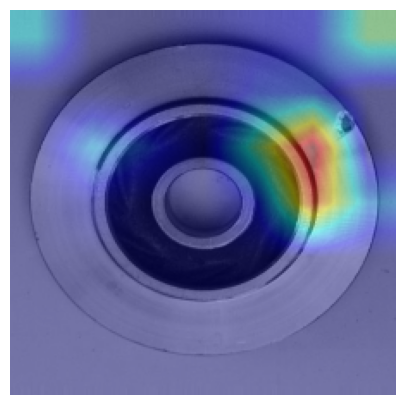

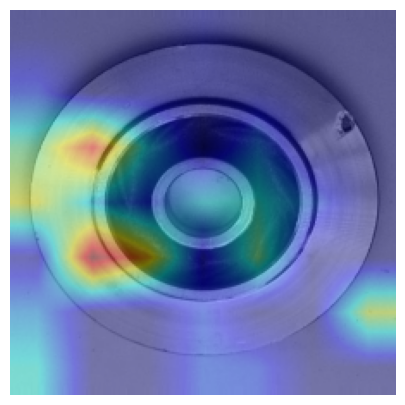

In [1]:
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
from torchvision.models import efficientnet_b0
from torch import nn
from PIL import Image
import cv2

# 모델 로드 및 수정 함수
def load_model(name, num_classes, pretrained):
    model = efficientnet_b0(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    if not pretrained:
        if name == "배선고정불량.pth":
            model.load_state_dict(torch.load(name, map_location='cpu'))
        else:
            model = efficientnet_b0(pretrained=False)
            num_ftrs = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    model = model.to('cpu')
    model.eval()
    return model

# 특성 맵 추출을 위한 훅 등록
final_conv = 'features'
activated_features = None
def hook_fn(module, input, output):
    global activated_features
    activated_features = output.detach()

if __name__ == "__main__":
    device = torch.device("cpu")
    model_names = ["efficientnet_b0_weights_pretrained.pth", "배선고정불량.pth", "efficientnet_b0_weights_notPretrained.pth"]
    pretrained_status = [True, False, False]

    img = Image.open('C:/pratice_data/casting/data/def_front/cast_def_0_93.jpeg')
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img_cv = cv2.resize(img_cv, (224, 224))
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_img = transform(img).unsqueeze(0).to(device)

    for i, model_name in enumerate(model_names):
        model = load_model(model_name, 2, pretrained_status[i])
        handle = model._modules.get(final_conv).register_forward_hook(hook_fn)

        output = model(input_img)
        weight_softmax = model.classifier[1].weight.data
        class_idx = torch.argmax(output)

        cam = torch.mm(weight_softmax[class_idx].unsqueeze(0), activated_features.reshape((activated_features.size(1), -1)))
        cam = cam.reshape(activated_features.shape[2], activated_features.shape[3])
        cam = F.relu(cam)
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze(0).squeeze(0)
        cam_img = cam.cpu().numpy() / cam.max()

        # CAM을 원본 이미지 위에 반투명하게 표시
        heatmap = cv2.applyColorMap(np.uint8(255*cam_img), cv2.COLORMAP_JET)
        result = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
